# Dynamics of a Stochastic Prey - Predator Model

📄 [Haokun Qi, Xinzhu Meng, *"Dynamics of a stochastic predator-prey model with fear effect and hunting cooperation"*, in Journal of Applied Mathematics and Computing, **2023**](https://doi.org/10.1007/s12190-022-01746-7)

In this notebook I'll present the implementation of the stochastic prey - predator dynamical system presented in [<a href="#ref1">1</a>], toghether with an analysis of the main result that can be obtained from numerical simulations of the system and an exploration of parameters effect on the model behavior.

### Imports

We'll first import necessary packages and implemented classes to run the notebook.

In [58]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.integrate import quad
from scipy import optimize
import pickle

# Seed and random generator
np.random.seed(123456)
from numpy.random import Generator, PCG64
rng = Generator(PCG64())

# Fixed tolerance for comparisons
EPSILON: float = 1e-8

# Implemented classes
from simulator import EulerMaruyama, Milstein, RungeKutta
from utils import plot_simulation, plot_white_shot, pdf

### Model Definition and Parameters

The predator-prey model with fear effect and hunting cooperation proposed in [<a href="#ref1">1</a>] is described by the following deterministic model:

$$
\begin{cases}
    \frac{du}{dt} = \frac{r_0 u}{1 + k \alpha v} - \beta u^2 - \frac{(p + \alpha v) u v}{1 + h (p + \alpha v) u}\\
    \frac{dv}{dt} = \frac{\theta (p + \alpha v) u v}{1 + h (p + \alpha v) u} - m v
\end{cases}
\tag{1}
$$

where the parameters assume the following meaning:

| **Parameter** | **Description** |
|---|---|
| u = u(t) | Prey density |
| v = v(t) | Predator density |
| $r_0$ | Prey birth rate |
| $\alpha$ | Predator hunting cooperation rate |
| $\beta$ | Competition strenght betwen preys |
| $\theta$ |Conversion efficiency |
| $k$ | Fear level induced by predator |
| $h$ | Predator handling time of prey |
| $m$ | Predator death rate |
| $p$ | Predator attack rate |


As the authors argue, populations are subject to random environmental disturbances in real life. Hence, environmental noise is an indispensable factor to consider when modelling populations. To this extent, they propose the following stochastic prey - predator model with fear effect and hunting cooperation factor:

$$
\begin{cases}
    \frac{du}{dt} = \left[\frac{r_0 u}{1 + k \alpha v} - \beta u^2 - \frac{(p + \alpha v) u v}{1 + h (p + \alpha v) u}\right]dt + u(\sigma_{11} + \sigma_{12} u) dW_1(t)\\
    \frac{dv}{dt} = \left[\frac{\theta (p + \alpha v) u v}{1 + h (p + \alpha v) u} - m v\right]dt + v(\sigma_{21} + \sigma_{22} v) dW_2(t)
\end{cases}
\tag{2}
$$

where $\sigma_{ij} > 0$ are the intensity weights of the white noise and $dW_1(t), dW_2(t)$ are mutually independent standard Brownian motions.

Therefore, according to this mode we first define the parameter values and the noise intensity weights.

In [59]:
# Model Parameters
r0 = 2
p = 0.5
k = 1.5
h = 1.2
beta = 0.5
theta = 0.6
alpha = 0.24
m = 0.34

# Noise parameters
sigma = np.array([
    [1e-2, 1e-2],
    [1e-2, 1e-2]
])

Then, we need to also define the associated **drift function** $f: \mathbb{R}^2 \to \mathbb{R}^2$ and **diffusion function** $g: \mathbb{R}^2 \to \mathbb{R}^2$ of the model, as well as the first derivatives of the componennts of the latter due to the chosen simulation algorithm as explained later.\
Notice that these functions are necessairly vector functions sice the state space is bidimensional: $(u, v) \in \mathbb{R}^2_{+}$. Hence:

$$
f(u, v) = \begin{bmatrix}
    \frac{r_0 u}{1 + k \alpha v} - \beta u^2 - \frac{(p + \alpha v) u v}{1 + h (p + \alpha v) u}\\
    \frac{\theta (p + \alpha v) u v}{1 + h (p + \alpha v) u} - m v
\end{bmatrix}
$$

$$
g(u, v) = \begin{bmatrix}
    u(\sigma_{11} + \sigma_{12} u)\\
    v(\sigma_{21} + \sigma_{22} v)
\end{bmatrix}
$$

and also, for simplicity:

$$
g'(u, v) = \begin{bmatrix}
    \frac{dg_u(u,v)}{du}\\
    \frac{dg_v(u,v)}{dv}\\
\end{bmatrix} 
= \begin{bmatrix}
    \sigma_{11} + 2 \sigma_{12} u\\
    \sigma_{21} + 2 \sigma_{22} v
\end{bmatrix}
$$

In [60]:
# Drift function
def f(x, t):
    u, v = x
    f_u = ((r0*u) / (1 + k*alpha*v)) - beta*(u**2) - (((p + alpha*v)*u*v) / (1 + h*(p + alpha*v)*u))
    f_v = ((theta*(p + alpha*v)*u*v) / (1 + h*(p + alpha*v)*u)) - m*v
    return np.array([f_u, f_v])

# Diffusion function
def g(x, t):
    u, v = x
    g_u = u*(sigma[0,0] + sigma[0, 1]*u)
    g_v = v*(sigma[1,0] + sigma[1, 1]*v)
    return np.array([g_u, g_v])

# First derivatives of diffusion function
def dg(x, t):
    u, v = x
    dg_u = sigma[0, 0] + 2*sigma[0, 1]*u
    dg_v = sigma[1, 0] + 2*sigma[1, 1]*v
    return np.array([dg_u, dg_v])

### Stationary distribution and model asymptotic behavior

Before actually simulating the system we can make some predictions on what could appen with the chosen set of parameters.\
In particular, in [<a href="#ref1">1</a>] it's stated that:

$$
\text{\textbf{THEOREM 3.1}:\quad when } R_1 = r_0 - \frac{1}{2}\sigma_{11}^2 < 0 \Rightarrow \text{prey } u(t) \to 0 \text{ will be extint}
$$

Moreover:

$$
\text{\textbf{THEOREM 3.2}:\quad when } R_2 = \frac{\theta}{h} - \left(m + \frac{1}{2}\sigma_{21}^2\right) < 0 \Rightarrow \text{predator } v(t) \to 0 \text{ will be extint}
$$

Therefore we define these quantities as `lambda` functions to check which values they assume as we change parameters later.

In [61]:
# Theorems quantities
R1 = lambda: r0 - 0.5 * sigma[0, 0]**2
R2 = lambda: (theta / h) - (m + 0.5 * sigma[1, 0]**2)

# Check theorems
print(f'R1 = {R1():.4f}.', 'If R1 < 0 negative ==> prey extinct')
print(f'R2 = {R2():.4f}.', 'If R2 < 0 negative ==> predator extinct')

R1 = 1.9999. If R1 < 0 negative ==> prey extinct
R2 = 0.1599. If R2 < 0 negative ==> predator extinct


Moreover, $\text{\textbf{THEOREM 3.3}}$ states that when $R_1 > 0$ and $R_2 < 0$, then the prey $u(t)$ will be persistent and has a unique stationary distribution described by:

$$
P_{eq.}(u) = \mathcal{A} \cdot u^{\frac{2r_0}{\sigma_{11}^2} - 2} (\sigma_{11} + \sigma_{12}u)^{-\frac{2r_0}{\sigma_{11}^2}-2} \cdot \text{exp}\left(\frac{2r_0(\beta\sigma_{11} + r_0\sigma_{12})}{r_0\sigma_{11}\sigma{12}(\sigma_{11}+\sigma_{12}u)}\right)
$$

with $\mathcal{A}$ normalization constant. This is a nice theoretical result but, in practice, it's hard to compute (*even numerically*) due to the high values assumed by the exponents...\
For the sake of completeness, we here leave a possible formalized implementation of how this probability function might be implemented. However, as stated, running the following code with noises around $\sim 10^{-2}$ or $\sim 10^{-1}$ will inevitably lead to overflow errors.

In [62]:
# Stationary prey distribution
def __unnormalized_P_eq(u):
    exponent1 = (2*r0 / sigma[0,0]**2) - 2
    exponent2 = - (2*r0 / sigma[0,0]**2) - 2
    exponent3 = (2*r0*(beta*sigma[0,0]+r0*sigma[0,1])) / (r0*sigma[0,0]*sigma[0,1]*(sigma[0,0]+sigma[0,1]*u))
    print(exponent1)
    print(exponent2)
    print(exponent3)
    return (u**exponent1) * ((sigma[0,0]+sigma[0,1]*u)**exponent2) * np.exp(exponent3)

# Normalized stationary prey distribution
def P_eq(u):
    # Integration bounds
    u_lower = 1e-6
    u_upper = np.inf
    
    # Normalization constant
    I, _ = quad(__unnormalized_P_eq, u_lower, u_upper)
    A = 1.0 / I
    
    # Apply to input u (scalar or array)
    if isinstance(u, np.ndarray):
        result = np.zeros_like(u, dtype=float)
        valid = u > 0
        result[valid] = A * np.array([__unnormalized_P_eq(val) for val in u[valid]])
        return result
    elif np.isscalar(u) and u > 0:
        return A * __unnormalized_P_eq(u)
    else:
        return 0.0

### Prey - Predator Persistence and Equilibria

We can hence simulate the model's temporal evolution from a set of initial conditions to numerically verify the previous statement and conduct a further parameter analysis. For this purpose, the `simulator.py` script presents the implementation of $3$ different simulation algorithms (*while only $1$ was used in the original paper [<a href="#ref1">1</a>]*): the *Euler-Maruyama* algorithm, the *Milstein* algorithm and the *Stochastic Runge-Kutta* scheme.

We'll first use the Milstein algoritm as it's the one adopted also in the original paper [<a href="#ref1">1</a>]. This means that we're approximating the real solution $x(t) = (u(t), v(t))^T$ on a temporal interval $[0, T]$ by partitioning the latter in $N$ discrete time-steps and iteratively compute the **discretized model** solution $x_k = (u_k, v_k)^T$ using the **Milstein update rule**:

$$
x_{k+1} = x_k + f(x_k) \Delta t + g(x_k) \sqrt{\Delta t} \xi_k + \frac{1}{2} g(x_k) g'(x_k) (\zeta_k^2 - 1) \Delta t
\tag{3}
$$

where $\Delta t = T / N$ is the uniform length of the single time-step and $\xi_k, \zeta_k$ for $k = 1, 2, \dots$ are independent Gaussian random variables $\mathcal{N}(0, 1)$.

The following cell implements this by running a simulation for $T=100$, $N=10000$, from $x(0) = (u(0), v(0)) = (3.6, 2.4)$.

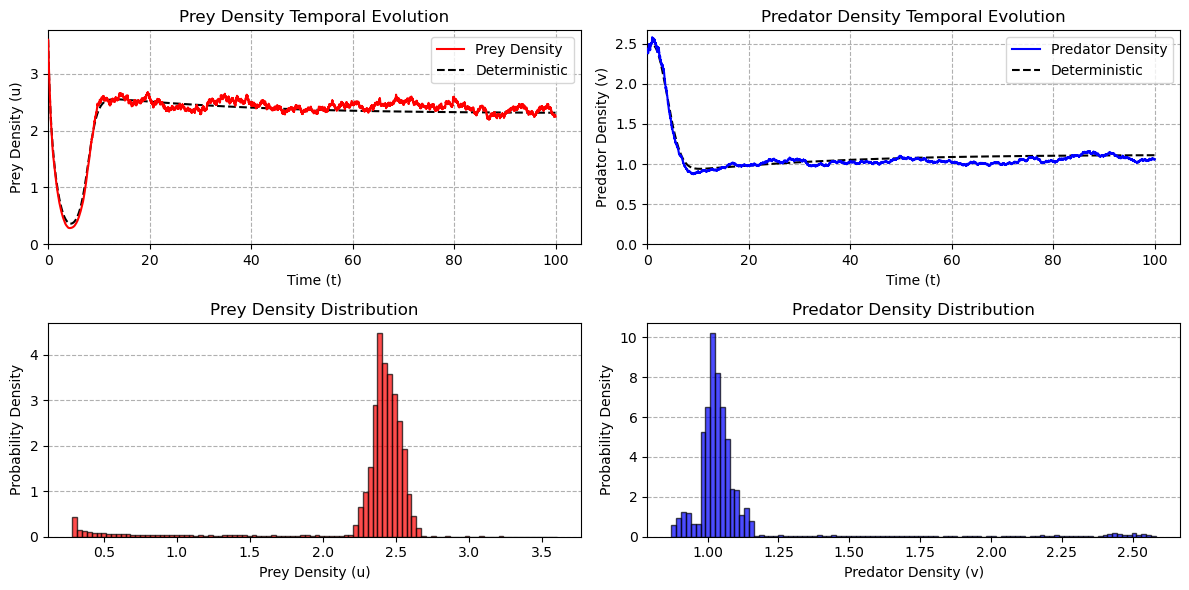

In [63]:
# Simulation variables
x0 = np.array([3.6, 2.4])   # Initial [prey, predator] densities
T = 100                     # Total simulation time
N = 10_000                  # Number of time steps

# Select simulator
simulator = Milstein(x0, T, N, f, g, dg)

# Run simulation 
x, t = simulator.simulate()

# Simulate deterministic system as well
x_det, t_det = simulator.simulate_deterministic()

# Plot simulation results
plot_simulation(x, t, x_det, t_det)

We can see that in this case, according to the theorems, the effect of noise is small since we set it on the order of $\sim 10^{-2}$ and the parameters are such that, according to the theorems above, both populations are persistent. Indeed, from the simulation we can notice that the populations evolve in time with small random variations around the trend of the deterministic model (*dotted black line in upper plots*).\
The probability density distributions resulting from the simulations have also been computed in the bottom plots.\
Motice that, independently of the initial conditions, both predator and prey populations seems to stabilize after some time around a seemingly equilibrium value. Therefore we might try to search for equilibrium points for the equivalent deterministic system, i.e. for values $(u^*, v^*)$ such that $f(u^*, v^*) = 0$. We do this numerically with SciPy's `optimize` module below.

In [7]:
# Define a time-independent function for root search
f_eq = lambda x: f(x, 0)

# Search roots from initial guess
x_guess = np.array([3.6, 2.4])
equilibria = optimize.root(f_eq, x_guess)

# Display result
if equilibria.success:
    x_eq = equilibria.x
    u_eq, v_eq = equilibria.x
    residual = np.linalg.norm(f_eq(equilibria.x))
    print(f"Equilibrium point: u = {u_eq:.4f}, v = {v_eq:.4f}")
    print(f"f(u_eq, v_eq, 0) = {f([u_eq, v_eq], 0)}")
    print(f"Residual: {residual}")
else:
    print("Failed to find equilibrium point.")

Equilibrium point: u = 2.3075, v = 1.1143
f(u_eq, v_eq, 0) = [ 8.65973959e-15 -8.54871729e-15]
Residual: 1.2168469792883275e-14


As expencted we found the equilibrium point $(u^*, v^*) = (2.3075, 1.1143)$. Notice that, if we simulate the original deterministic system starting from this value, the system evolution shows no dynamics at all, while the stochastic version only develops with random fluctuations around the equilibria as one would expect.

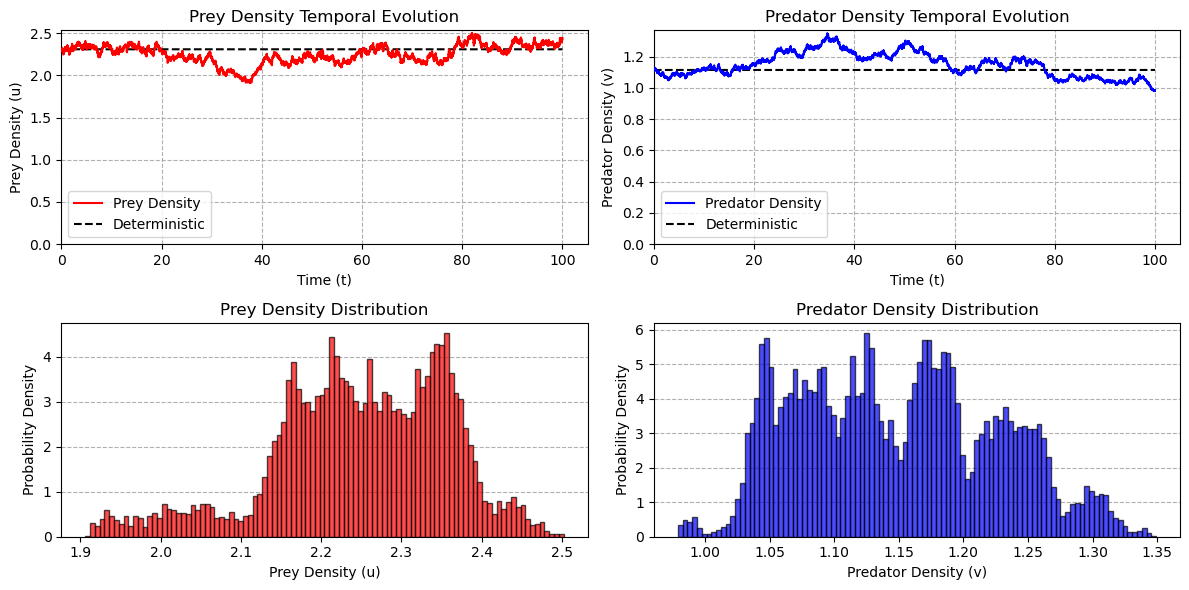

In [8]:
# Simulation variables
x0 = x_eq
T = 100
N = 10_000

# Select simulator
simulator = Milstein(x0, T, N, f, g, dg)

# Run simulation 
x, t = simulator.simulate()

# Simulate deterministic system as well
x_det, t_det = simulator.simulate_deterministic()

# Plot simulation results
plot_simulation(x, t, x_det, t_det)


We can also try to simulate the system multiple times from different initial conditions to check if it always converges to the same equilibrium asymptotic state.

In [9]:
# Set of initial conditions
IC = np.array([
    [4.0, 0.5],
    [4.0, 1.0],
    [3.0, 2.0],
    [3.0, 3.0],
    [4.0, 4.0],
    [1.0, 1.0],
    [2.0, 2.0],
    [2.0, 3.0],
    [2.0, 4.0],
    [1.0, 4.0],
])

# Simulation variables
x0 = IC[0]
T = 1000
N = 10_000
x_list = []

# Select simulator
simulator = Milstein(x0, T, N, f, g, dg)

# Run simulations
for x0 in IC:
    simulator.x0 = x0               # Set IC
    x, t = simulator.simulate()     # Run simulation
    x_list.append(x)                # Store result

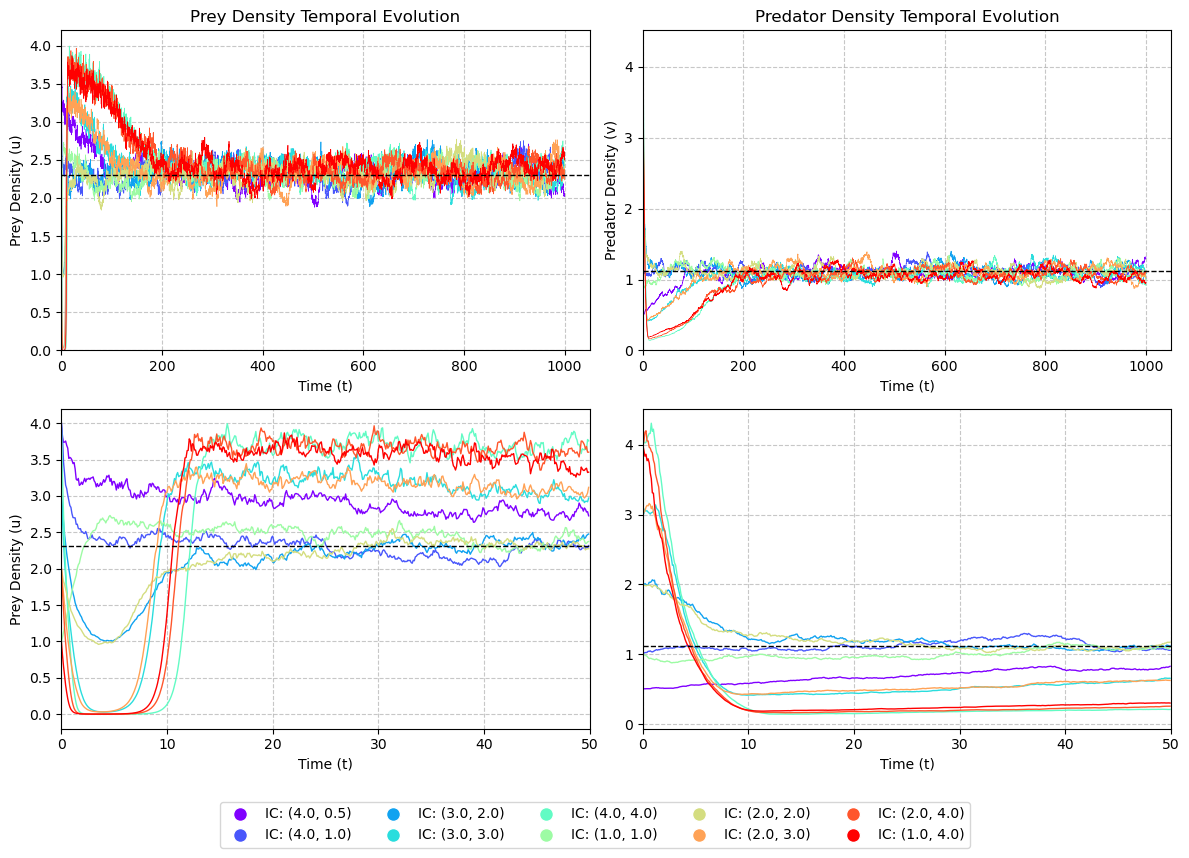

In [10]:
# Plot simulations results
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
colors = plt.cm.rainbow(np.linspace(0, 1, len(x_list)))
N_first = 500

for i, x in enumerate(x_list):
    # Prey trajectory
    ax[0,0].plot(t, x[:, 0], color=colors[i], label=f'IC: ({IC[i][0]}, {IC[i][1]})', lw=0.5)
    ax[1,0].plot(t[:N_first], x[:N_first, 0], color=colors[i], label=f'IC: ({IC[i][0]}, {IC[i][1]})', lw=1.0)

    # Predator trajectory
    ax[0,1].plot(t, x[:, 1], color=colors[i], lw=0.5)
    ax[1,1].plot(t[:N_first], x[:N_first, 1], color=colors[i], lw=1.0)

# Equilibrium
ax[0,0].axhline(y=x_eq[0], color='k', linestyle='--', lw=1)
ax[1,0].axhline(y=x_eq[0], color='k', linestyle='--', lw=1)
ax[0,1].axhline(y=x_eq[1], color='k', linestyle='--', lw=1)
ax[1,1].axhline(y=x_eq[1], color='k', linestyle='--', lw=1)

# Add subplot titles and labels
ax[0,0].set_title('Prey Density Temporal Evolution')
ax[0,0].set_xlabel('Time (t)')
ax[1,0].set_xlabel('Time (t)')
ax[0,0].set_ylabel('Prey Density (u)')
ax[1,0].set_ylabel('Prey Density (u)')
ax[0,0].set_xlim(0, None)
ax[1,0].set_xlim(0, N_first // 10)
ax[0,0].set_ylim(0, None)
ax[0,0].grid(linestyle='--', alpha=0.7)
ax[1,0].grid(linestyle='--', alpha=0.7)

ax[0,1].set_title('Predator Density Temporal Evolution')
ax[0,1].set_xlabel('Time (t)')
ax[1,1].set_xlabel('Time (t)')
ax[0,1].set_ylabel('Predator Density (v)')
ax[0,1].set_xlim(0, None)
ax[1,1].set_xlim(0, N_first // 10)
ax[0,1].set_ylim(0, None)
ax[0,1].grid(linestyle='--', alpha=0.7)
ax[1,1].grid(linestyle='--', alpha=0.7)

# Legend
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=fr"IC: ({IC[i][0]}, {IC[i][1]})") for i in range(len(colors))]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=5) #, fontsize='small')

plt.tight_layout(rect=[0, 0.01, 1, 1])
plt.show()

### Numerical Algorithms Comparison

We can also compare the quality of the Milstein algorithm w.r.t. other SDE simulation methods such as **Euler-Maruyama** algorithm that includes the update rule:

$$
x_{k+1} = x_k + f(x_k) \Delta t + g(x_k) \sqrt{\Delta t} \xi_k 
$$

or even the **Stochastic Runge-Kutta** algorihm, for which the iterative update rule dictates:

$$
x_{k+1} = x_k + f(x_k) \Delta t + g(x_k) \sqrt{\Delta t} \xi_k + \frac{1}{2} \left( g(x_k + f(x_k) \Delta t + g(x_k) \sqrt{\Delta t }) - g(x_k) \right) (\zeta_k^2 - 1) \sqrt{\Delta t}
$$

To qualitatively compare the simulation of these 3 methods, we therefore generate a single noise array containing the values of the noise for all time-steps.

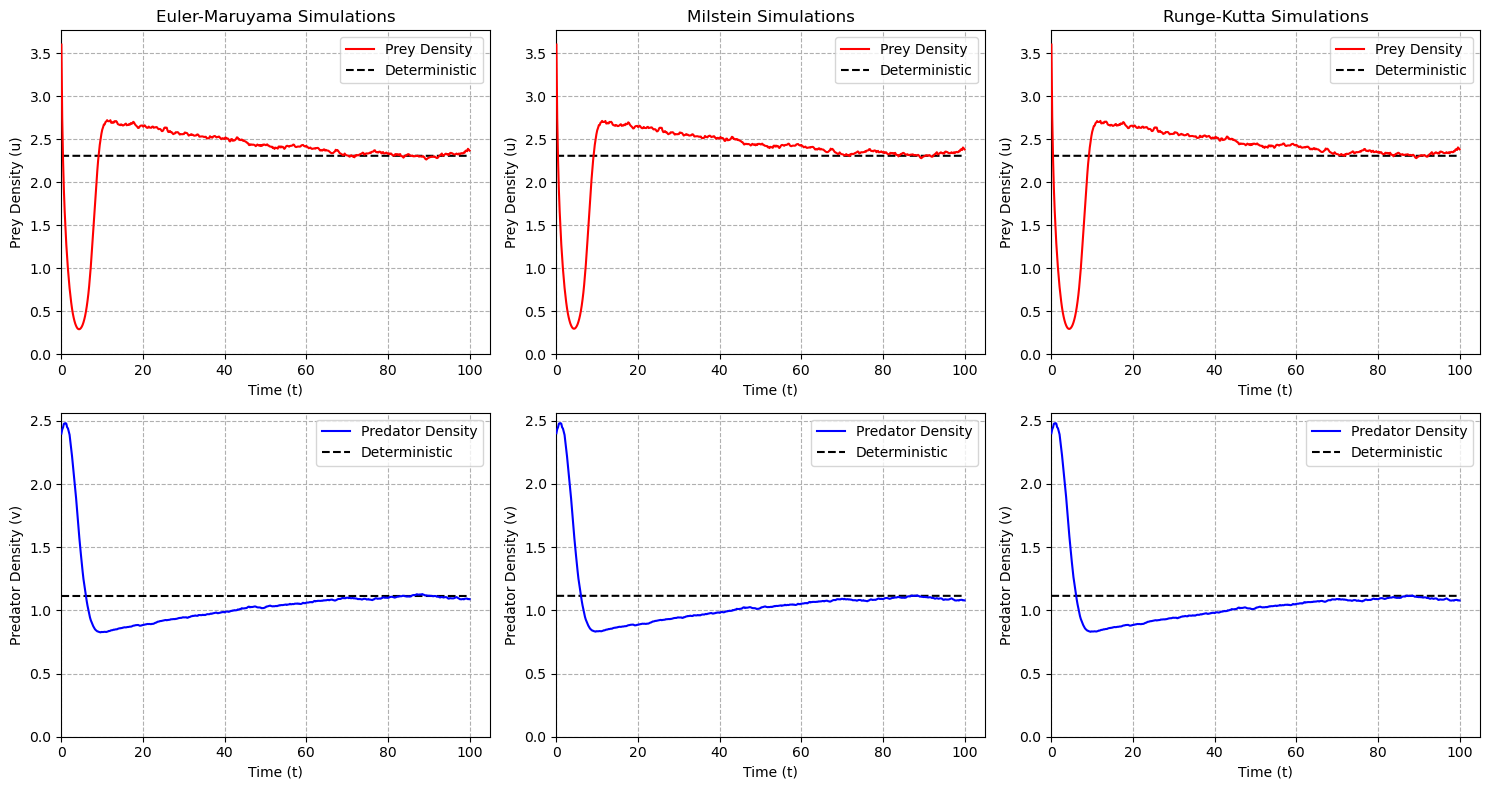

In [12]:
# Model Parameters
r0 = 2
p = 0.5
k = 1.5
h = 1.2
beta = 0.5
theta = 0.6
alpha = 0.24
m = 0.34

# Noise parameters
sigma = np.array([
    [1e-2, 1e-2],
    [1e-2, 1e-2]
])

# Simulation variables
x0 = x_eq
T = 100
N = 10_000

# Generate a unique noise vector for all 3 algorithms
dW = rng.normal(loc=0.0, scale=np.sqrt(T/N), size=(N, 2)) # 2: dimension of state space

# Change the discretization to check quality differences
N = 500

# Initialize the simulators
x0 = np.array([3.6, 2.4])   # Initial [prey, predator] densities
euler = EulerMaruyama(x0, T, N, f, g)
milstein = Milstein(x0, T, N, f, g, dg)
runge = RungeKutta(x0, T, N, f, g)

# Simulate with the 3 algorithms
x_e, t_e = euler.simulate_dW(dW)
x_m, t_m = milstein.simulate_dW(dW)
x_r, t_r = runge.simulate_dW(dW)

# Compare the results
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

# Euler-Maruyama (1st colmn)
ax[0,0].plot(t_e, x_e[:, 0], label='Prey Density', color='red', zorder=3)
if x_det is not None and t_det is not None:
    ax[0,0].plot(t_det, x_det[:, 0], label='Deterministic', color='black', linestyle='--', zorder=2)
ax[0,0].set_title('Euler-Maruyama Simulations')
ax[0,0].set_xlabel('Time (t)')
ax[0,0].set_ylabel('Prey Density (u)')
ax[0,0].set_xlim(0, None)
ax[0,0].set_ylim(0, None)
ax[0,0].grid(linestyle='--', zorder=1)
ax[0,0].legend()


ax[1,0].plot(t_e, x_e[:, 1], label='Predator Density', color='blue', zorder=3)
if x_det is not None and t_det is not None:
    ax[1,0].plot(t_det, x_det[:, 1], label='Deterministic', color='black', linestyle='--', zorder=2)
ax[1,0].set_xlabel('Time (t)')
ax[1,0].set_ylabel('Predator Density (v)')
ax[1,0].set_xlim(0, None)
ax[1,0].set_ylim(0, None)
ax[1,0].grid(linestyle='--', zorder=1)
ax[1,0].legend()

# Milstein (2nd column)
ax[0,1].plot(t_m, x_m[:, 0], label='Prey Density', color='red', zorder=3)
if x_det is not None and t_det is not None:
    ax[0,1].plot(t_det, x_det[:, 0], label='Deterministic', color='black', linestyle='--', zorder=2)
ax[0,1].set_title('Milstein Simulations')
ax[0,1].set_xlabel('Time (t)')
ax[0,1].set_ylabel('Prey Density (u)')
ax[0,1].set_xlim(0, None)
ax[0,1].set_ylim(0, None)
ax[0,1].grid(linestyle='--', zorder=1)
ax[0,1].legend()

ax[1,1].plot(t_m, x_m[:, 1], label='Predator Density', color='blue', zorder=3)
if x_det is not None and t_det is not None:
    ax[1,1].plot(t_det, x_det[:, 1], label='Deterministic', color='black', linestyle='--', zorder=2)
ax[1,1].set_xlabel('Time (t)')
ax[1,1].set_ylabel('Predator Density (v)')
ax[1,1].set_xlim(0, None)
ax[1,1].set_ylim(0, None)
ax[1,1].grid(linestyle='--', zorder=1)
ax[1,1].legend()

# Runge-Kutta (3rd column)
ax[0,2].plot(t_r, x_r[:, 0], label='Prey Density', color='red', zorder=3)
if x_det is not None and t_det is not None:
    ax[0,2].plot(t_det, x_det[:, 0], label='Deterministic', color='black', linestyle='--', zorder=2)
ax[0,2].set_title('Runge-Kutta Simulations')
ax[0,2].set_xlabel('Time (t)')
ax[0,2].set_ylabel('Prey Density (u)')
ax[0,2].set_xlim(0, None)
ax[0,2].set_ylim(0, None)
ax[0,2].grid(linestyle='--', zorder=1)
ax[0,2].legend()

ax[1,2].plot(t_r, x_r[:, 1], label='Predator Density', color='blue', zorder=3)
if x_det is not None and t_det is not None:
    ax[1,2].plot(t_det, x_det[:, 1], label='Deterministic', color='black', linestyle='--', zorder=2)
ax[1,2].set_xlabel('Time (t)')
ax[1,2].set_ylabel('Predator Density (v)')
ax[1,2].set_xlim(0, None)
ax[1,2].set_ylim(0, None)
ax[1,2].grid(linestyle='--', zorder=1)
ax[1,2].legend()

plt.tight_layout()
plt.show()

We can see that all algorithms simulate very well the system under the same noise intensities and no real differece in quality emerges from the plots. Hence, we can keep using the Milstein algorithm to keep consistency and comparison capability with the original paper [<a href="#ref1">1</a>].

### Noise - Induced predator extinction

When we increase $\sigma_{21}$ from $0.01$ to $0.6$, we can observe a different behaviour in the system as the predator goes extinct accoridng to the previous theorems. We hence simulate this scenario with the same parameters as above except for the noise.

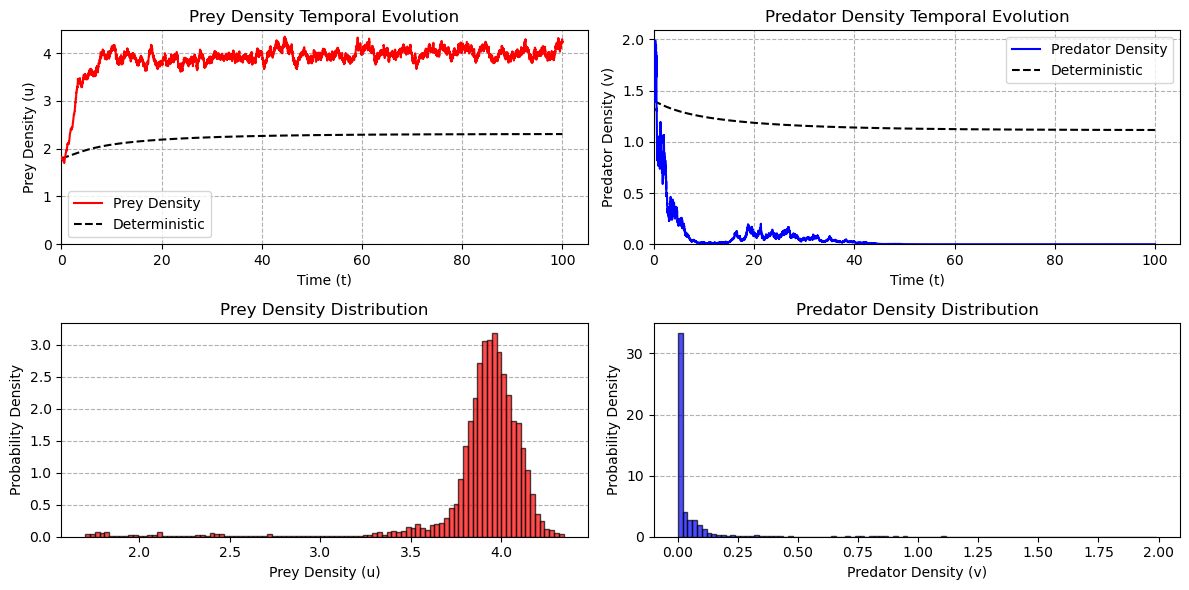

In [93]:
# Predator goes extinct scenario

# Model Parameters
r0 = 2
p = 0.5
k = 1.5
h = 1.2
beta = 0.5
theta = 0.6
alpha = 0.24
m = 0.34

# Noise parameters
sigma = np.array([
    [1e-2, 1e-2],
    [0.6, 1e-2]
])

# Run simulation
x0 = np.array([1.8, 1.4])   # Initial [prey, predator] densities
T = 100                     # Total simulation time
N = 10_000                  # Number of time steps

simulator = Milstein(x0, T, N, f, g, dg)
x, t = simulator.simulate()
x_det, t_det = simulator.simulate_deterministic()

plot_simulation(x, t, x_det, t_det)

We can clearly see that noise has a huge impact n te predator population if we compare the stochastic evolution w.r.t to the deterministic one. Of course such change also influence the prey population which stabilizes to a higher asymptotic value w.r.t. the deterministic one.

We can verrify the values of $R_1$ and $R_2$ are as expected also in this case.

In [94]:
print(f'R1 = {R1():.4f}.', 'If R1 < 0 negative ==> prey extinct')
print(f'R2 = {R2():.4f}.', 'If R2 < 0 negative ==> predator extinct')

R1 = 1.9999. If R1 < 0 negative ==> prey extinct
R2 = -0.0200. If R2 < 0 negative ==> predator extinct


### Hunting Cooperation Effect

By increasing the value of the hunting cooperation parameter $\alpha$ to $0.8$ we can notice that both population are able to reach a steady state equilibrium.

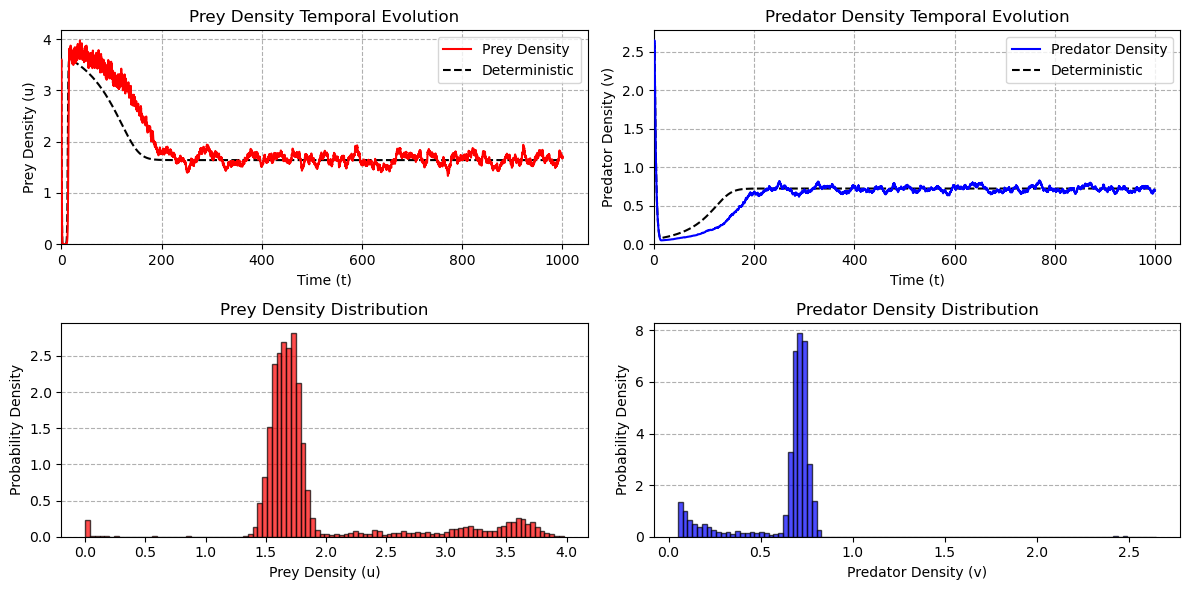

In [41]:
# Effect of hunting cooperation

# Model Parameters
r0 = 2
p = 0.5
k = 1.5
h = 1.2
beta = 0.5
theta = 0.6
alpha = 0.8 # from 0.24 to 0.8
m = 0.34

# Noise parameters
sigma = np.array([
    [1e-2, 1e-2],
    [1e-2, 1e-2]
])

# Run simulation
x0 = np.array([3.6, 2.4])   # Initial [prey, predator] densities
T = 1000                    # Total simulation time
N = 10_000                  # Number of time steps

simulator = Milstein(x0, T, N, f, g, dg)
x, t = simulator.simulate()
x_det, t_det = simulator.simulate_deterministic()

plot_simulation(x, t, x_det, t_det)

The speed at which the equilibrium is reached depends on the initial conditions: this can be verified by taking pairs of $(u(0), v(0))$ closer to the equilibrium values and noticing that, even in the presence of noise, the system reaches the predicted stationary distribution.

However we can further study the effect of the hunting cooperation parameter by simulating the system for multiple values of the parameter $\alpha$. For instance here we picked $7$ different values of the parameter and we analyze the outcome of a single simulation.

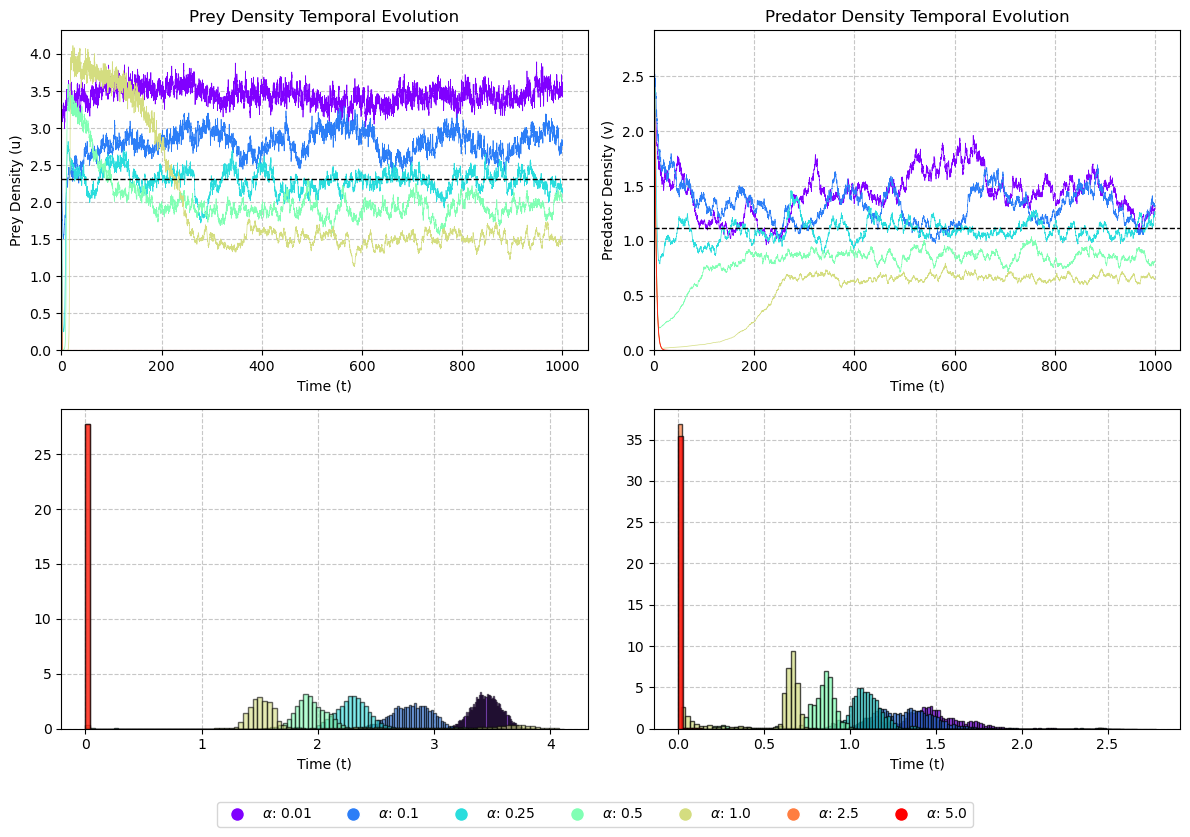

In [22]:
# Model Parameters
r0 = 2
p = 0.5
h = 1.2
beta = 0.5
theta = 0.6
m = 0.34

alphas = [0.01, 0.1, 0.25, 0.5, 1.0, 2.5, 5.0]
k = 1.5

# Noise parameters
sigma = np.array([
    [1e-2, 1e-2],
    [1e-2, 1e-2]
])

# Simulation variables
x0 = np.array([3.6, 2.4])   # Initial [prey, predator] densities
T = 1000                     # Total simulation time
N = 10_000                  # Number of time steps
x_list = []

# Select simulator
simulator = Milstein(x0, T, N, f, g, dg)

# Run simulations
for alpha in alphas:
    x, t = simulator.simulate()     # Run the simulation
    x_list.append(x)                # Append to list

# Plot simulations results
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
colors = plt.cm.rainbow(np.linspace(0, 1, len(x_list)))

for i, x in enumerate(x_list):
    
    # Compute pdf 
    u_pdf, u_bins, v_pdf, v_bins = pdf(x)
    
    # Prey trajectory
    ax[0,0].plot(t, x[:, 0], color=colors[i], label=fr"$\alpha$: {alphas[i]}", lw=0.5)

    # Predator trajectory
    ax[0,1].plot(t, x[:, 1], color=colors[i], lw=0.5)

    # Prey PDF
    bin_centers = 0.5 * (u_bins[1:] + u_bins[:-1])
    ax[1,0].bar(bin_centers, u_pdf, width=(u_bins[1] - u_bins[0]), alpha=0.6, color=colors[i], edgecolor='black', zorder=2)

    # Predator density PDF
    bin_centers = 0.5 * (v_bins[1:] + v_bins[:-1])
    ax[1,1].bar(bin_centers, v_pdf, width=(v_bins[1] - v_bins[0]), alpha=0.7, color=colors[i], edgecolor='black', zorder=2)

# Equilibrium
ax[0,0].axhline(y=x_eq[0], color='k', linestyle='--', lw=1)
ax[0,1].axhline(y=x_eq[1], color='k', linestyle='--', lw=1)

# Add subplot titles and labels
ax[0,0].set_title('Prey Density Temporal Evolution')
ax[0,0].set_xlabel('Time (t)')
ax[1,0].set_xlabel('Time (t)')
ax[0,0].set_ylabel('Prey Density (u)')
ax[0,0].set_xlim(0, None)
ax[0,0].set_ylim(0, None)
ax[0,0].grid(linestyle='--', alpha=0.7)
ax[1,0].grid(linestyle='--', alpha=0.7)

ax[0,1].set_title('Predator Density Temporal Evolution')
ax[0,1].set_xlabel('Time (t)')
ax[1,1].set_xlabel('Time (t)')
ax[0,1].set_ylabel('Predator Density (v)')
ax[0,1].set_xlim(0, None)
ax[0,1].set_ylim(0, None)
ax[0,1].grid(linestyle='--', alpha=0.7)
ax[1,1].grid(linestyle='--', alpha=0.7)

# Legend
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=fr"$\alpha$: {alphas[i]}") for i in range(len(colors))]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=8)

plt.tight_layout(rect=[0, 0.01, 1, 1])
plt.show()

Notice how low values of hunting cooperation result in a higher steady state prey density and oscillating predator population (i.e. flat probability density), while as we increase the parameter $\alpha$ we see the prey population decreasing on average but also the predator following a similar pattern as well as the drop in prey makes more difficult for the predator to reproduce.\
These are of course results of a single simulation hence we now run $100$ simulations for each chosen value of the parameter $\alpha$ and see if the overall probability desity obtained at the end respects this pattern.

Processing alpha = 0.01
Processing alpha = 0.1
Processing alpha = 0.25
Processing alpha = 0.5
Processing alpha = 1.0
Processing alpha = 2.5
Processing alpha = 5.0


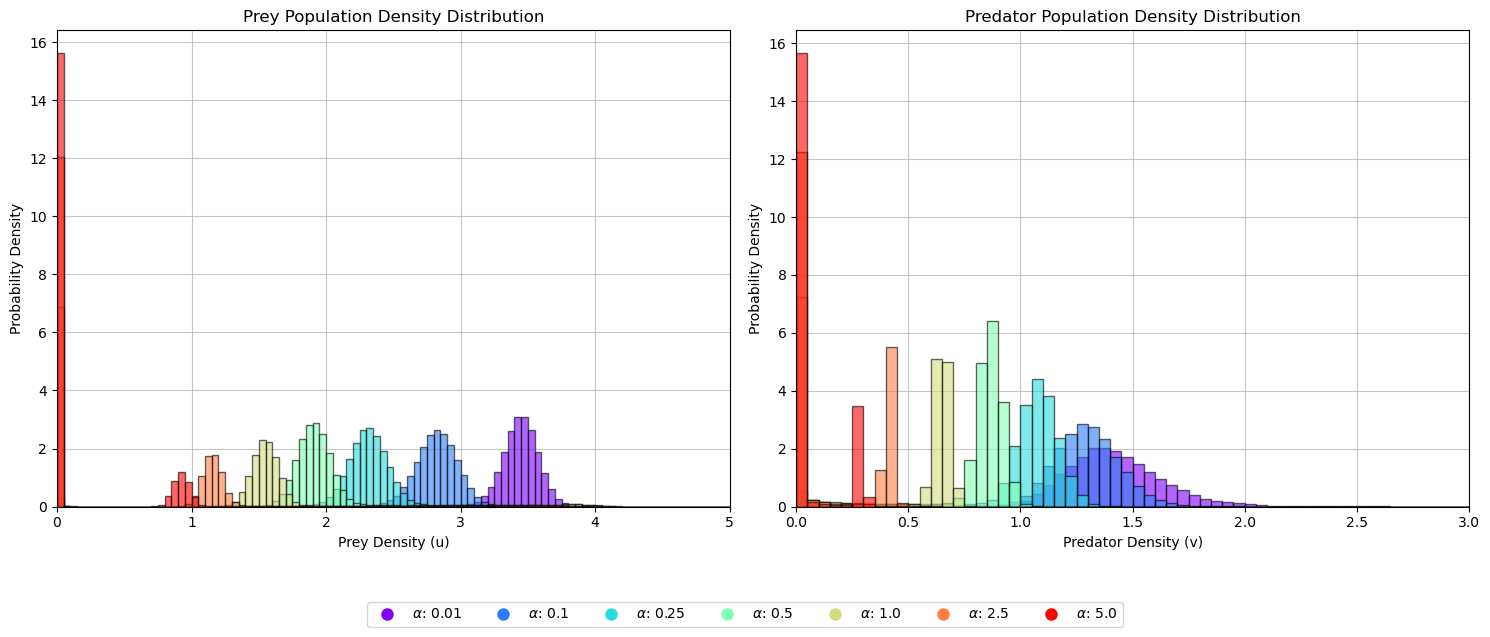

In [23]:
# Model Parameters
r0 = 2
p = 0.5
h = 1.2
beta = 0.5
theta = 0.6
m = 0.34

alphas = [0.01, 0.1, 0.25, 0.5, 1.0, 2.5, 5.0]
k = 1.5

# Noise parameters
sigma = np.array([
    [1e-2, 1e-2],
    [1e-2, 1e-2]
])

# Simulation variables
T = 1000
N = 10_000
Nsim = 100

# Initialize storage for combined histograms
u_range = (0, 5)  # Define appropriate range for prey density
v_range = (0, 5)  # Define appropriate range for predator density
n_bins = 100

# Storage for combined distributions
alphas_pdfs = {}

# Run simulations for different alphas
for alpha in alphas:
    # Initialize accumulators for this alpha value
    u_combined_counts = np.zeros(n_bins)
    v_combined_counts = np.zeros(n_bins)
    total_points = 0  # Track total number of data points
    
    print(f"Processing alpha = {alpha}")
    
    # Run simulations
    for sim in range(Nsim):
        # Pick a random initial condition
        x0 = np.random.uniform(0.5, 4.0, size=(2,))
        simulator = Milstein(x0, T, N, f, g, dg)
        
        # Run simulation
        x, t = simulator.simulate()
        u, v = x[:, 0], x[:, 1]
        
        # Calculate histograms with consistent bin edges
        u_counts, u_bins = np.histogram(u, bins=n_bins, range=u_range)
        v_counts, v_bins = np.histogram(v, bins=n_bins, range=v_range)
        
        # Accumulate counts
        u_combined_counts += u_counts
        v_combined_counts += v_counts
        total_points += len(u)
    
    # Normalize to get PDFs
    u_pdf = u_combined_counts / (total_points * (u_bins[1] - u_bins[0]))
    v_pdf = v_combined_counts / (total_points * (v_bins[1] - v_bins[0]))
    
    # Store results for this alpha
    alphas_pdfs[alpha] = {
        'u_pdf': u_pdf,
        'u_bins': u_bins,
        'v_pdf': v_pdf,
        'v_bins': v_bins
    }


# Plot the combined PDFs for different alpha values
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
colors = plt.cm.rainbow(np.linspace(0, 1, len(alphas)))

# Plot prey (u) PDFs
for i, alpha in enumerate(alphas):
    pdf_data = alphas_pdfs[alpha]
    bin_centers = 0.5 * (pdf_data['u_bins'][1:] + pdf_data['u_bins'][:-1])
    ax[0].bar(bin_centers, pdf_data['u_pdf'], width=(pdf_data['u_bins'][1] - pdf_data['u_bins'][0]), alpha=0.6, color=colors[i], edgecolor='black', zorder=2)

# Plot predator (v) PDFs
for i, alpha in enumerate(alphas):
    pdf_data = alphas_pdfs[alpha]
    bin_centers = 0.5 * (pdf_data['v_bins'][1:] + pdf_data['v_bins'][:-1])
    ax[1].bar(bin_centers, pdf_data['v_pdf'], width=(pdf_data['v_bins'][1] - pdf_data['v_bins'][0]), alpha=0.6, color=colors[i], edgecolor='black', zorder=2)

# Set titles and labels
ax[0].set_title('Prey Population Density Distribution')
ax[0].set_xlabel('Prey Density (u)')
ax[0].set_ylabel('Probability Density')
ax[0].grid(True, alpha=0.7)
ax[0].set_xlim(0, 5)
ax[0].set_ylim(0, None)

ax[1].set_title('Predator Population Density Distribution')
ax[1].set_xlabel('Predator Density (v)')
ax[1].set_ylabel('Probability Density')
ax[1].grid(True, alpha=0.7)
ax[1].set_xlim(0, 3)
ax[1].set_ylim(0, None)

# Create legend
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=fr"$\alpha$: {alphas[i]}") for i in range(len(colors))]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=8)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

### Fear effect

Similarly, we can change the value of the fear effect $k$ to see how the system behaves.

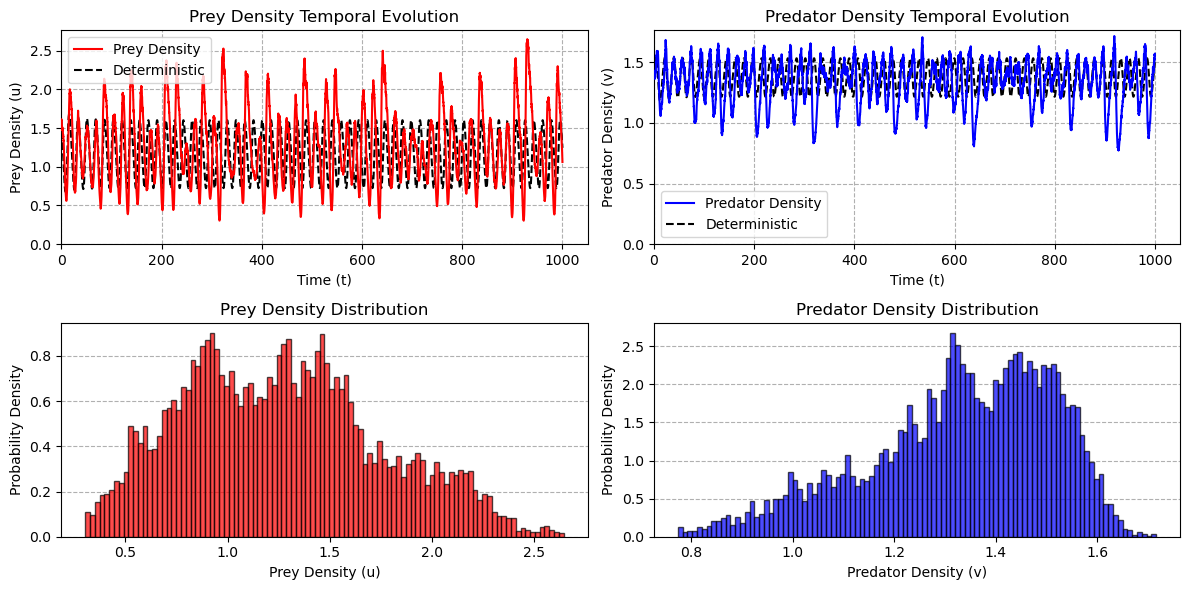

In [24]:
# Fear effect result

# Model Parameters
r0 = 2
p = 0.5
k = 0.5
h = 1.2
beta = 0.5
theta = 0.6
alpha = 0.8
m = 0.34

# Noise parameters
sigma = np.array([
    [1e-2, 1e-2],
    [1e-2, 1e-2]
])

# Run simulation
x0 = np.array([1.6, 1.4])   # Initial [prey, predator] densities
T = 1000                    # Total simulation time
N = 10_000                  # Number of time steps

simulator = Milstein(x0, T, N, f, g, dg)
x, t = simulator.simulate()
x_det, t_det = simulator.simulate_deterministic()

plot_simulation(x, t, x_det, t_det)

Notice how the selected values of the parameters, even with small noise ($\sim 10^{-2}$) result in larger oscillations compared to the deterministic system, which in turn result in *"wider"* probability density distributions, but the populations remain persistent in time.

However, we verify that increasing noise value still leads to the extinction of the predator population as anticipated in previous simulations.

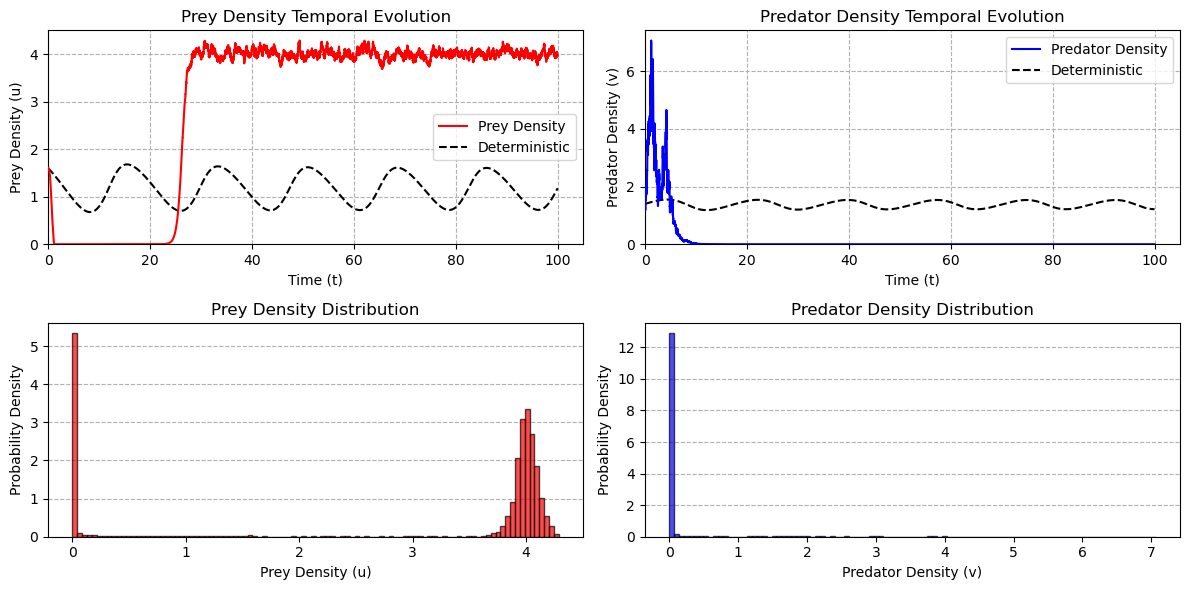

In [25]:
# Fear effect result

# Model Parameters
r0 = 2
p = 0.5
k = 0.5
h = 1.2
beta = 0.5
theta = 0.6
alpha = 0.8
m = 0.34

# Noise parameters
sigma = np.array([
    [1e-2, 1e-2],
    [0.6, 1e-2]
])

# Run simulation
x0 = np.array([1.6, 1.4])   # Initial [prey, predator] densities
T = 100                     # Total simulation time
N = 10_000                  # Number of time steps

simulator = Milstein(x0, T, N, f, g, dg)
x, t = simulator.simulate()
x_det, t_det = simulator.simulate_deterministic()

plot_simulation(x, t, x_det, t_det)

Similarly to what we did for the hunting cooperation parameter, we can aso change multiple values for the fear effect parameter $k$ and see the resulting probability distributions for mutliple simulations.

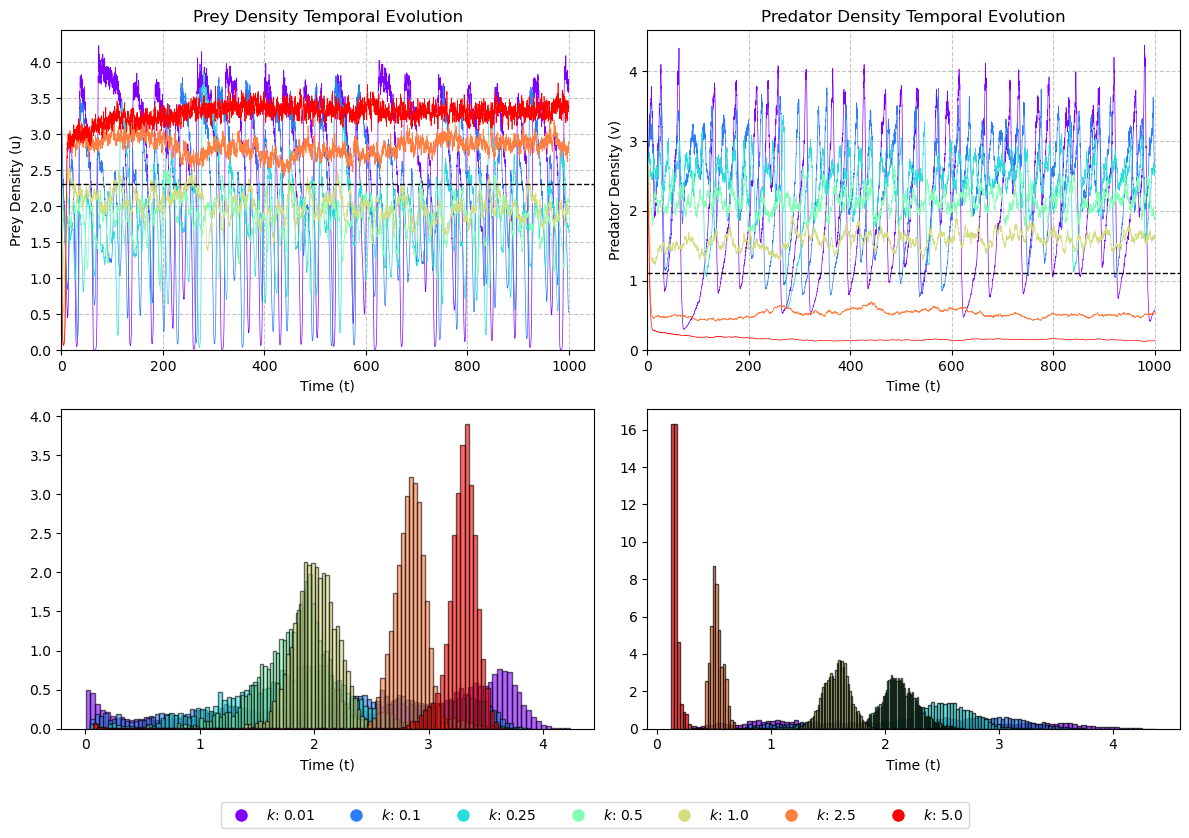

In [ ]:
# Model Parameters
r0 = 2
p = 0.5
h = 1.2
beta = 0.5
theta = 0.6
m = 0.34

alpha = 0.24
kappas = [0.01, 0.1, 0.25, 0.5, 1.0, 2.5, 5.0]

# Noise parameters
sigma = np.array([
    [1e-2, 1e-2],
    [1e-2, 1e-2]
])

# Simulation variables
x0 = np.array([3.6, 2.4])   # Initial [prey, predator] densities
T = 1000                     # Total simulation time
N = 10_000                  # Number of time steps
x_list = []

# Select simulator
simulator = Milstein(x0, T, N, f, g, dg)

# Run simulations
for k in kappas:
    x, t = simulator.simulate()     # Run the simulation
    x_list.append(x)                # Append to list

# Plot simulations results
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
colors = plt.cm.rainbow(np.linspace(0, 1, len(x_list)))

for i, x in enumerate(x_list):
    
    # Compute pdf 
    u_pdf, u_bins, v_pdf, v_bins = pdf(x)
    
    # Prey trajectory
    ax[0,0].plot(t, x[:, 0], color=colors[i], label=fr"$k$: {kappas[i]}", lw=0.5)

    # Predator trajectory
    ax[0,1].plot(t, x[:, 1], color=colors[i], lw=0.5)

    # Prey PDF
    bin_centers = 0.5 * (u_bins[1:] + u_bins[:-1])
    ax[1,0].bar(bin_centers, u_pdf, width=(u_bins[1] - u_bins[0]), alpha=0.6, color=colors[i], edgecolor='black', zorder=2)

    # Predator density PDF
    bin_centers = 0.5 * (v_bins[1:] + v_bins[:-1])
    ax[1,1].bar(bin_centers, v_pdf, width=(v_bins[1] - v_bins[0]), alpha=0.7, color=colors[i], edgecolor='black', zorder=2)

# Equilibrium
ax[0,0].axhline(y=x_eq[0], color='k', linestyle='--', lw=1)
ax[0,1].axhline(y=x_eq[1], color='k', linestyle='--', lw=1)

# Add subplot titles and labels
ax[0,0].set_title('Prey Density Temporal Evolution')
ax[0,0].set_xlabel('Time (t)')
ax[1,0].set_xlabel('Time (t)')
ax[0,0].set_ylabel('Prey Density (u)')
ax[0,0].set_xlim(0, None)
ax[0,0].set_ylim(0, None)
ax[0,0].grid(linestyle='--', alpha=0.7)
ax[1,0].grid(linestyle='--', alpha=0.7)

ax[0,1].set_title('Predator Density Temporal Evolution')
ax[0,1].set_xlabel('Time (t)')
ax[1,1].set_xlabel('Time (t)')
ax[0,1].set_ylabel('Predator Density (v)')
ax[0,1].set_xlim(0, None)
ax[0,1].set_ylim(0, None)
ax[0,1].grid(linestyle='--', alpha=0.7)
ax[1,1].grid(linestyle='--', alpha=0.7)

# Legend
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=fr"$k$: {kappas[i]}") for i in range(len(colors))]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=8)

plt.tight_layout(rect=[0, 0.01, 1, 1])
plt.show()

In this case, notice how low values of prey fear results in high oscillations in the system and hece both probability distrivutions present high variance and lower peaks overall. On the other hand, as expected, increasing the prey fear effect towards the predator slowly decreases the variance in the prey populations and brings the average towards greater values as seen in the red and orange curves. The predator population is instead deemed towards lower average and variance values as we increse the fear effect, ad that's also understandable.\
This behavior is also confirmed by simulating the prevuious multiple times from random initial conditions and then collecting the resulting overall probability desities as seen below.

Processing k = 0.1
Processing k = 0.25
Processing k = 0.5
Processing k = 1.0
Processing k = 2.5
Processing k = 5.0
Processing k = 7.5
Processing k = 10


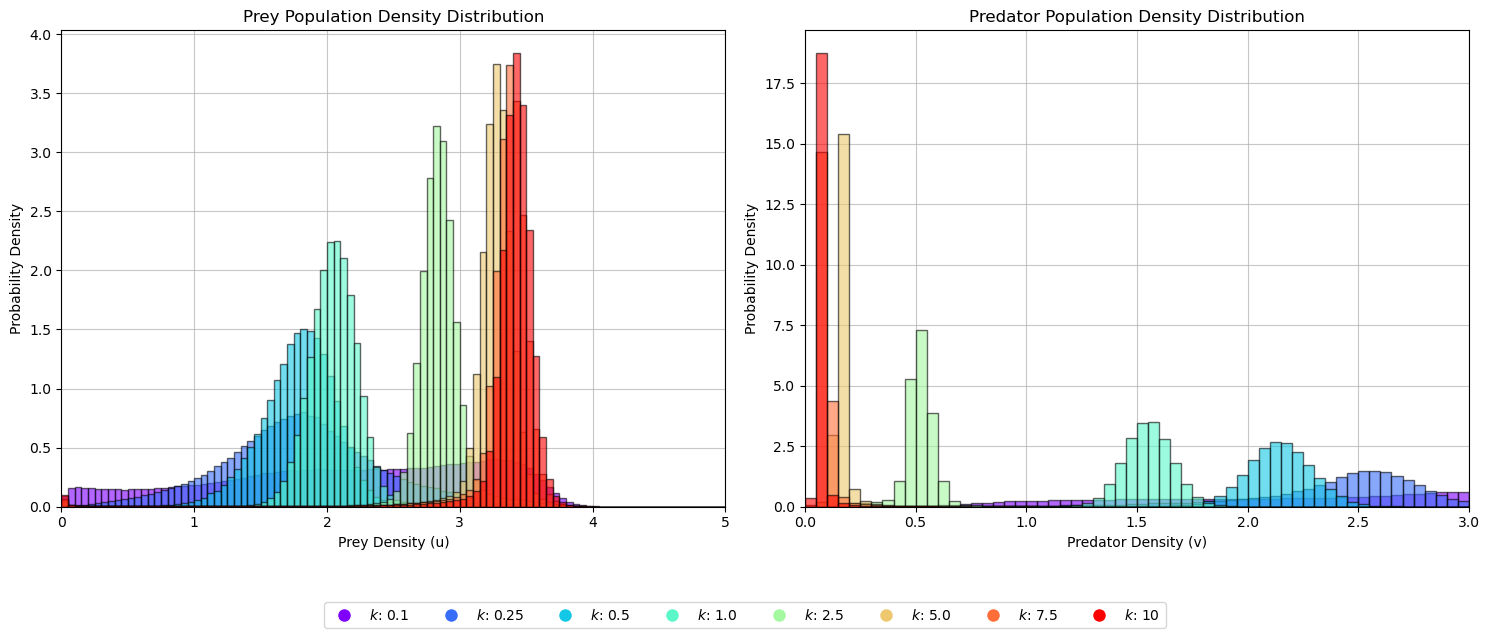

In [28]:
# Model Parameters
r0 = 2
p = 0.5
h = 1.2
beta = 0.5
theta = 0.6
m = 0.34

alpha = 0.24 
kappas = [0.1, 0.25, 0.5, 1.0, 2.5, 5.0, 7.5, 10]

# Noise parameters
sigma = np.array([
    [1e-2, 1e-2],
    [1e-2, 1e-2]
])

# Simulation variables
T = 1000
N = 10_000
Nsim = 100

# Initialize storage for combined histograms
u_range = (0, 5)  # Define appropriate range for prey density
v_range = (0, 5)  # Define appropriate range for predator density
n_bins = 100

# Storage for combined distributions
kappas_pdfs = {}

# Run simulations for different alphas
for k in kappas:
    # Initialize accumulators for this alpha value
    u_combined_counts = np.zeros(n_bins)
    v_combined_counts = np.zeros(n_bins)
    total_points = 0  # Track total number of data points
    
    print(f"Processing k = {k}")
    
    # Run simulations
    for sim in range(Nsim):
        # Pick a random initial condition
        x0 = np.random.uniform(0.5, 4.0, size=(2,))
        simulator = Milstein(x0, T, N, f, g, dg)
        
        # Run simulation
        x, t = simulator.simulate()
        u, v = x[:, 0], x[:, 1]
        
        # Calculate histograms with consistent bin edges
        u_counts, u_bins = np.histogram(u, bins=n_bins, range=u_range)
        v_counts, v_bins = np.histogram(v, bins=n_bins, range=v_range)
        
        # Accumulate counts
        u_combined_counts += u_counts
        v_combined_counts += v_counts
        total_points += len(u)
    
    # Normalize to get PDFs
    u_pdf = u_combined_counts / (total_points * (u_bins[1] - u_bins[0]))
    v_pdf = v_combined_counts / (total_points * (v_bins[1] - v_bins[0]))
    
    # Store results for this alpha
    kappas_pdfs[k] = {
        'u_pdf': u_pdf,
        'u_bins': u_bins,
        'v_pdf': v_pdf,
        'v_bins': v_bins
    }

# Plot the combined PDFs for different k values
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
colors = plt.cm.rainbow(np.linspace(0, 1, len(kappas)))

# Plot prey (u) PDFs
for i, k in enumerate(kappas):
    pdf_data = kappas_pdfs[k]
    bin_centers = 0.5 * (pdf_data['u_bins'][1:] + pdf_data['u_bins'][:-1])
    ax[0].bar(bin_centers, pdf_data['u_pdf'], width=(pdf_data['u_bins'][1] - pdf_data['u_bins'][0]), alpha=0.6, color=colors[i], edgecolor='black', zorder=2)

# Plot predator (v) PDFs
for i, k in enumerate(kappas):
    pdf_data = kappas_pdfs[k]
    bin_centers = 0.5 * (pdf_data['v_bins'][1:] + pdf_data['v_bins'][:-1])
    ax[1].bar(bin_centers, pdf_data['v_pdf'], width=(pdf_data['v_bins'][1] - pdf_data['v_bins'][0]), alpha=0.6, color=colors[i], edgecolor='black', zorder=2)

# Set titles and labels
ax[0].set_title('Prey Population Density Distribution')
ax[0].set_xlabel('Prey Density (u)')
ax[0].set_ylabel('Probability Density')
ax[0].grid(True, alpha=0.7)
ax[0].set_xlim(0, 5)
ax[0].set_ylim(0, None)

ax[1].set_title('Predator Population Density Distribution')
ax[1].set_xlabel('Predator Density (v)')
ax[1].set_ylabel('Probability Density')
ax[1].grid(True, alpha=0.7)
ax[1].set_xlim(0, 3)
ax[1].set_ylim(0, None)

# Create legend
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=fr"$k$: {kappas[i]}") for i in range(len(colors))]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=8)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

### Combined effect of hunting cooperation and fear effect

An interesting analysis to perform is to study the combined effect of hunting cooperation and fear effect together on the system.\ For this purpose, in the following we pick multiple values for both $\alpha$ and $k$, for each possible combination of values we run multiple simulations each from random initial conditions and then we collect the mean and variance of the reached steady state at each simulation.

Since the following cell might take some time to run depending on your hardware, you can also skip it and directly the final pre-computed results dictionary with `pickle`. 

In [29]:
# Model Parameters
r0 = 2
p = 0.5
h = 1.2
beta = 0.5
theta = 0.6
m = 0.34

alphas = [
    1e-2,
    2.5e-2,
    5e-2,
    7.5e-2,
    1e-1,
    2.5e-1,
    5e-1,
    7.5e-1,
    1,
    2.5,
    5,
    7.5,
    10
]

kappas = [
    1e-2,
    2.5e-2,
    5e-2,
    7.5e-2,
    1e-1,
    2.5e-1,
    5e-1,
    7.5e-1,
    1,
    2.5,
    5,
    7.5,
    10
]

# Noise parameters
sigma = np.array([
    [1e-2, 1e-2],
    [1e-2, 1e-2]
])

# Simulation variables
T = 1000
N = 10_000
Nsim = 100
N_last = 1000


# Initialize the result trajectories dictionary
results: dict = {}

# Run simulations for different combinations of parameters
for alpha in alphas:
    for k in kappas:

        u_list = []
        v_list = []
        
        for _ in range(Nsim):
            # Pick a random initial condition
            x0 = np.random.uniform(0.5, 4.0, size=(2,))
            simulator = Milstein(x0, T, N, f, g, dg)
            
            # Run simulation
            x, t = simulator.simulate()
            u_list.append(x[:,0])
            v_list.append(x[:,1])
            
        # Obtain steady states of simulations
        u_steady = np.array([u[-N_last:] for u in u_list]).flatten()
        v_steady = np.array([v[-N_last:] for v in v_list]).flatten()
            
        # Compute mean and variance of the steady state
        u_mean = np.mean(u_steady)
        u_var = np.var(u_steady)
        v_mean = np.mean(v_steady)
        v_var = np.var(v_steady) 
            
        # Append results to dictionary
        results[(alpha, k)] = {
            'u_mean': u_mean,
            'u_var': u_var,
            'v_mean': v_mean,
            'v_var': v_var
        }

# Save the results dictionary to a file
with open('new_prey_predator_results.pkl', 'wb') as file:
    pickle.dump(results, file)

In [ ]:
# (Optional) Load pre-computed results from file
# with open('prey_predator_results.pkl', 'rb') as file:
#     results = pickle.load(file)

We can hence plot the mean steady states of the two populations for differnt combinations of parameters to study the overall system behavior.

In [30]:
# Prey mean steady state

# Create meshgrid
alpha_values = sorted({a for a, k in results.keys()})
kappa_values = sorted({k for a, k in results.keys()})
u_mean = np.array([[results[(a, k)]['u_mean'] for k in kappa_values] for a in alpha_values])
k_grid, alpha_grid = np.meshgrid(kappa_values, alpha_values)  # grid for surface

# Plot 
fig = make_subplots(
    rows=1, cols=2,
    column_widths=[0.6, 0.4],
    specs=[[{"type": "surface"}, {"type": "contour"}]],
    horizontal_spacing=0.08,
)

# 3D surface 
fig.add_trace(
    go.Surface(
        x=k_grid, y=alpha_grid, z=u_mean,
        coloraxis="coloraxis"
    ),
    row=1, col=1
)

# 2D contour heatmap 
fig.add_trace(
    go.Contour(
        x=kappa_values, y=alpha_values, z=u_mean,
        colorscale='Viridis',
        # contours_coloring="heatmap",
        # coloraxis="coloraxis",
        showscale=False
    ),
    row=1, col=2
)

fig.update_layout(
    title="Mean Prey Steady State for different α and k values",
    scene=dict(
        xaxis_title="k",
        yaxis_title="α",
        zaxis_title="Mean Steady State u",
        camera=dict(eye=dict(x=1.35, y=1.35, z=0.8))
    ),
    coloraxis=dict(
        colorscale="Viridis",
        colorbar=dict(title="Mean", x=1.02) 
    ),
    width=1200, height=600,
    margin=dict(l=40, r=120, t=60, b=40)
)
fig.update_xaxes(title_text="k", row=1, col=2, automargin=True, title_standoff=8)
fig.update_yaxes(title_text="α", row=1, col=2, automargin=True, title_standoff=8)

fig.show()


In [31]:
# Predator mean steady state

# meshgrid
alpha_values = sorted({a for a, k in results.keys()})
kappa_values = sorted({k for a, k in results.keys()})
v_mean = np.array([[results[(a, k)]['v_mean'] for k in kappa_values] for a in alpha_values])
k_grid, alpha_grid = np.meshgrid(kappa_values, alpha_values)  # grid for surface

# Plot
fig = make_subplots(
    rows=1, cols=2,
    column_widths=[0.6, 0.4],
    specs=[[{"type": "surface"}, {"type": "contour"}]],
    horizontal_spacing=0.08,
)

# 3D surface
fig.add_trace(
    go.Surface(
        x=k_grid, y=alpha_grid, z=v_mean,
        coloraxis="coloraxis" 
    ),
    row=1, col=1
)

# 2D contour heatmap 
fig.add_trace(
    go.Contour(
        x=kappa_values, y=alpha_values, z=v_mean,
        colorscale='Viridis',
        # contours_coloring="heatmap",
        # coloraxis="coloraxis",
        showscale=False
    ),
    row=1, col=2
)

# Shared colorbar + layout
fig.update_layout(
    title="Mean Predator Steady State for different α and k values",
    scene=dict(
        xaxis_title="k",
        yaxis_title="α",
        zaxis_title="Mean Steady State u",
        camera=dict(eye=dict(x=1.35, y=1.35, z=0.8))
    ),
    coloraxis=dict(
        colorscale="Viridis",
        colorbar=dict(title="Mean", x=1.02)
    ),
    width=1200, height=600,
    margin=dict(l=40, r=120, t=60, b=40)
)
fig.update_xaxes(title_text="k", row=1, col=2, automargin=True, title_standoff=8)
fig.update_yaxes(title_text="α", row=1, col=2, automargin=True, title_standoff=8)

fig.show()

### White Shot Noise

An additional exploration that could be done with this model consists in swapping the Gaussia noise with **white shot noise**: an impulsive noies that acts as an impulsive force with a stochastic intensity withing some determined bounds.
By definition, white shot noise  can be described as a series of impulses randomly distributed in time following an exponential distribution with rate $\lambda$, which amplitude is bounded in a given range $[-\text{intensity},+\text{intensity}]$.\
In this case, the model is similarly described by euations $(2)$, with a small difference:

$$
\begin{cases}
    \frac{du}{dt} = \left[\frac{r_0 u}{1 + k \alpha v} - \beta u^2 - \frac{(p + \alpha v) u v}{1 + h (p + \alpha v) u}\right]dt + u(\sigma_{11} + \sigma_{12} u) \sum_i \xi_i \delta(t - t_i)\\
    \frac{dv}{dt} = \left[\frac{\theta (p + \alpha v) u v}{1 + h (p + \alpha v) u} - m v\right]dt + v(\sigma_{21} + \sigma_{22} v) \sum_i \zeta_i \delta(t - t_i)
\end{cases}
\tag{4}
$$

where $\delta(t-t_i)$ is the Dirac delta function indicating the presence of an impulsive event at time $t_i$ and $\xi_i, \zeta_i$ are the amplitudes of the impulses.\
In the implemented simulator class, the main idea to simulate this implusive events has therefore been the following:

* given an input rate $\lambda$, a sequence of event times $\{t_i\}$ is sampled with exponential distribution;
* for each event time $t_i$, correponding impulsive white shot noise values $\xi_i, \zeta_i$ are sampled with uniform distribution in a determined intensity range.

This effectively allows to obtain an `impulses` array (whose length equals the number of discretization steps for the time interval studied) which contains ``mostly'' zeros (*actually, it depends on the $\lambda$ chosen*) with the exception of the components associated to the occurrence of an impulsive event, which will contain the uniformly sampled intensity of the white shot noise. Therefore, during the simulation, the deterministic part of the equation is computed using the chosed iterative update method while the stochastic noise is added only when an actual event has been sampled for that specific time interval.

Below we see the results of the white shot noise simulation with the parameters from the first example.

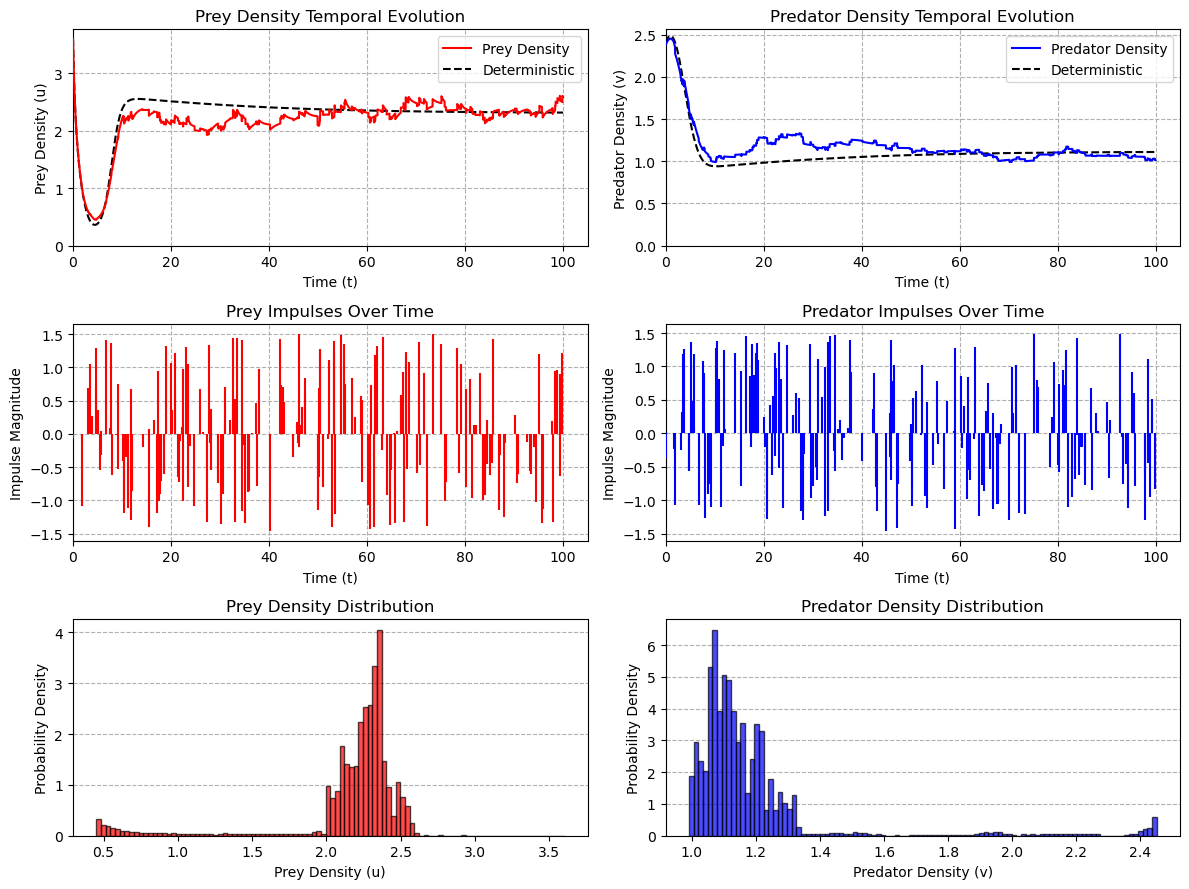

In [16]:
# Model Parameters
r0 = 2
p = 0.5
k = 1.5
h = 1.2
beta = 0.5
theta = 0.6
alpha = 0.24
m = 0.34

# Noise parameters
sigma = np.array([
    [1e-2, 1e-2],
    [1e-2, 1e-2]
])

# White Shot Noise Parameters
lambd = 2.0
intensity = 1.5

# Simulation variables
x0 = np.array([3.6, 2.4])   # Initial [prey, predator] densities
T = 100                     # Total simulation time
N = 10_000                  # Number of time steps

# Select simulator
simulator = Milstein(x0, T, N, f, g, dg)

# Run simulation 
x, t = simulator.simulate_shot_noise(lambd, intensity)

# Simulate deterministic system as well
x_det, t_det = simulator.simulate_deterministic()

# Plot simulation results
plot_white_shot(x, t, simulator.impulses, x_det, t_det)


The behavior of the system results being similar to the one of the original Gaussian noise stochastic system with small differences related to the specific choice of white shot noise generation parameters.\
However, it's worth checking that hte behaviour of the system is maintained even in this case. Specifically, we can check if increasing the $\sigma_{12}$ noise parameter still results in the predator extinction as expected from theory.

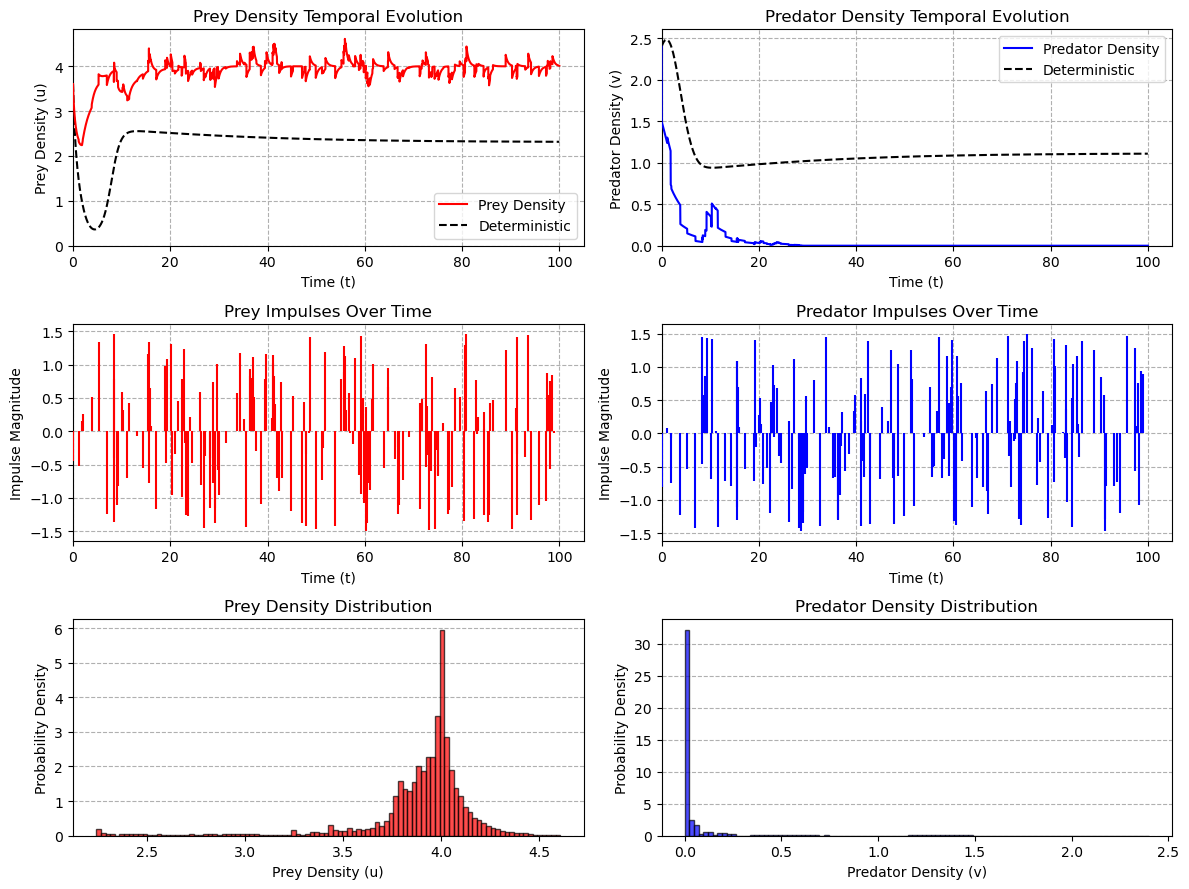

In [17]:
# Model Parameters
r0 = 2
p = 0.5
k = 1.5
h = 1.2
beta = 0.5
theta = 0.6
alpha = 0.24
m = 0.34

# Noise parameters
sigma = np.array([
    [1e-2, 1e-2],
    [0.6, 1e-2]
])

# White Shot Noise Parameters
lambd = 2.0
intensity = 1.5

# Simulation variables
x0 = np.array([3.6, 2.4])   # Initial [prey, predator] densities
T = 100                     # Total simulation time
N = 10_000                  # Number of time steps

# Select simulator
simulator = Milstein(x0, T, N, f, g, dg)

# Run simulation 
x, t = simulator.simulate_shot_noise(lambd, intensity)

# Simulate deterministic system as well
x_det, t_det = simulator.simulate_deterministic()

# Plot simulation results
plot_white_shot(x, t, simulator.impulses, x_det, t_det)


Indeed, the noise-induced predator extinction is confirmed even in the presence of white shot noise. However, in some instances if we set a high enough intensity and $\lambda$ exponential rate for the sampling of the white shot noise it's possible that a certain number of positive nois impulses are scheduled close in time and we might observe a re-population of the predator species, as we attempt to do in the following cell (*you might need to run it a few times utile the desired behavior is observed*). However, even in such cases we can always observe that the predator inevitably goes extinct after some time after repopulation.

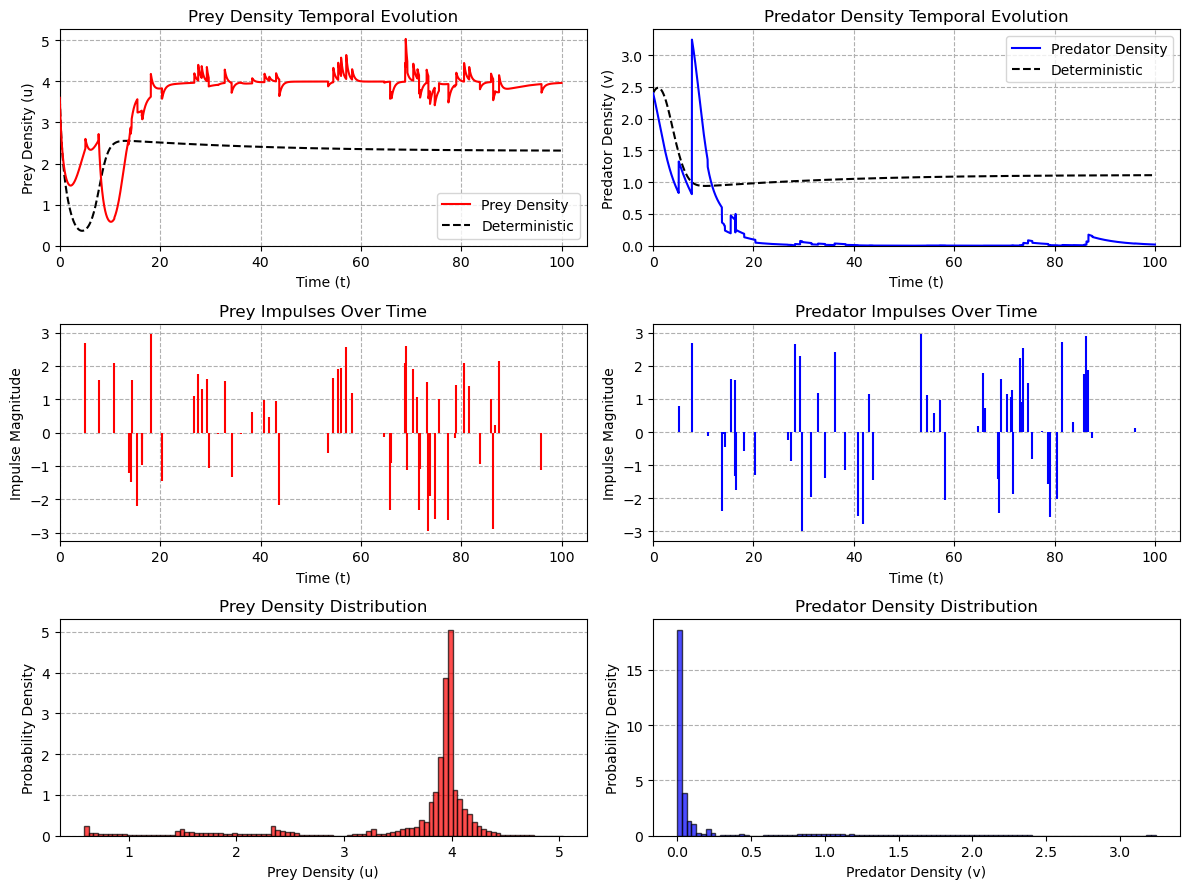

In [30]:
# Model Parameters
r0 = 2
p = 0.5
k = 1.5
h = 1.2
beta = 0.5
theta = 0.6
alpha = 0.24
m = 0.34

# Noise parameters
sigma = np.array([
    [1e-2, 1e-2],
    [0.6, 1e-2]
])

# White Shot Noise Parameters
lambd = 0.8
intensity = 3.0

# Simulation variables
x0 = np.array([3.6, 2.4])   # Initial [prey, predator] densities
T = 100                     # Total simulation time
N = 10_000                  # Number of time steps

# Select simulator
simulator = Milstein(x0, T, N, f, g, dg)

# Run simulation 
x, t = simulator.simulate_shot_noise(lambd, intensity)

# Simulate deterministic system as well
x_det, t_det = simulator.simulate_deterministic()

# Plot simulation results
plot_white_shot(x, t, simulator.impulses, x_det, t_det)



### References

<a id="ref1"></a>
[1] Haokun Qi, Xinzhu Meng, *"Dynamics of a stochastic predator-prey model with fear effect and hunting cooperation"*, in Journal of Applied Mathematics and Computing, vol. 69, pp. 2077–2103, 2023, doi: [https://doi.org/10.1007/s12190-022-01746-7](https://doi.org/10.1007/s12190-022-01746-7)